In [1]:
import gc

import pandas as pd
import numpy as np

from datetime import datetime as dt
from functools import partial, wraps

from plasticc.training import train_and_validate
from plasticc.featurize import featurize, process_meta

In [2]:
np.warnings.filterwarnings('ignore')
gc.enable()

I'm defining custom modelling and cv function here in order to explote parameters easier

### Default training and features' parameters

In [3]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None, 
        'skewness' : None,
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [4]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

In [5]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 7,
    'n_estimators': 1024,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.5,
    'drop_rate': 0.173,
    'learning_rate': 0.0267,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.1,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75
}

## Data processing

In [6]:
%%time
meta_train = process_meta('../data/raw/training_set_metadata.csv')
train = pd.read_csv('../data/raw/training_set.csv')

CPU times: user 1.72 s, sys: 344 ms, total: 2.07 s
Wall time: 1.41 s


In [7]:
%%time
X = featurize(train, meta_train, aggs, fcp)

Feature Extraction: 100%|██████████| 20/20 [00:01<00:00, 18.90it/s]


CPU times: user 1min 3s, sys: 1.98 s, total: 1min 5s
Wall time: 27.1 s


In [8]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [9]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 152 ms, sys: 4 ms, total: 156 ms
Wall time: 7.9 ms


### Exploration of generated features

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
default_colnames_to_drop = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf'
])
id_colname = 'object_id'
default_feature_colnames = [col for col in X.columns if col not in default_colnames_to_drop]

In [12]:
X_default = X[default_feature_colnames]

In [13]:
col_uniq_vals = pd.Series([len(X_default[col].unique()) for col in X_default.columns], index=X_default.columns)

In [14]:
most_categorical = col_uniq_vals.sort_values(ascending=True).head(10)

All columns have more than 100 values, after seeing plots below I believe some of them can be clustered into categorical ones (`flux_length` especially)

flux__length, unique=122, mean=181.15507135575942 std=91.7522055340327


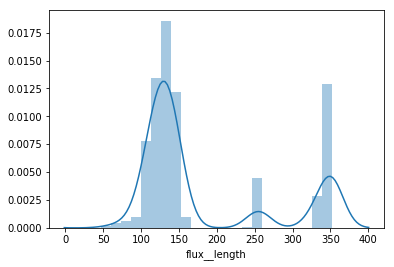

flux__longest_strike_above_mean, unique=123, mean=14.186289500509684 std=14.822502967043388


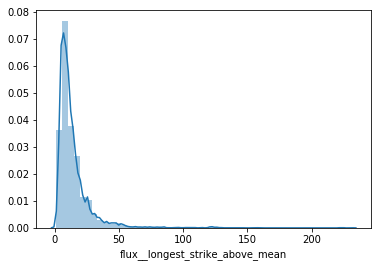

flux_by_flux_ratio_sq__longest_strike_above_mean, unique=146, mean=10.57250254841998 std=19.41361204458239


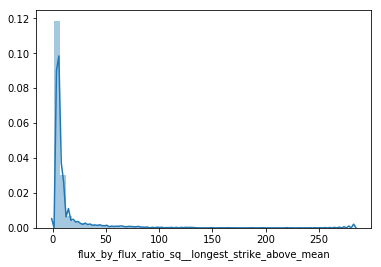

flux__longest_strike_below_mean, unique=262, mean=35.06651376146789 std=48.44919757580438


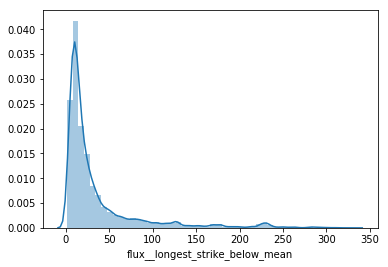

flux_by_flux_ratio_sq__longest_strike_below_mean, unique=325, mean=90.90812945973497 std=72.23568180034897


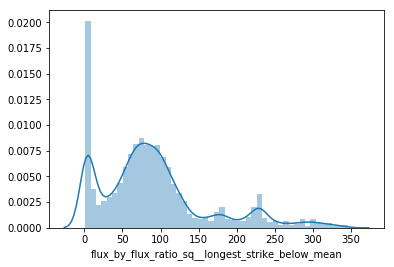

mwebv, unique=593, mean=0.0819525993883792 std=0.15059768370757728


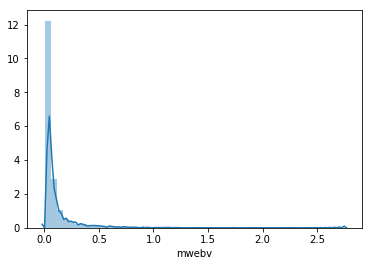

detected_mean, unique=2400, mean=0.15739001314527845 std=0.22337820404062128


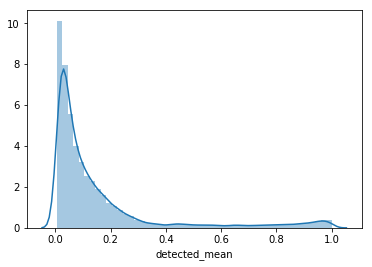

hostgal_photoz_err, unique=2456, mean=0.15569469928644242 std=0.3003673567476212


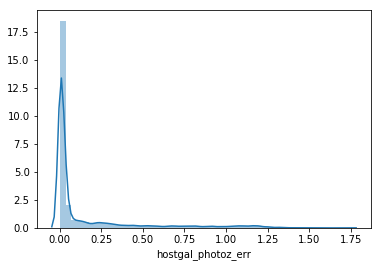

hostgal_photoz, unique=4025, mean=0.35788450560652396 std=0.5455515546524672


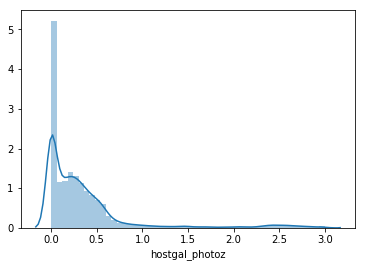

distmod, unique=5301, mean=29.03935459989806 std=18.937866809844596


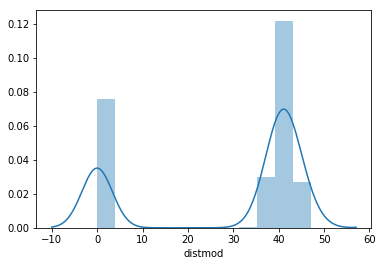

In [15]:
for col in most_categorical.index:
    print(f"{col}, unique={most_categorical[col]}, mean={X_default[col].mean()} std={X_default[col].std()}")
    sns.distplot(X_default[col])
    plt.show()

As we can see, the features were not scaled - we will do this first and see whether it improved the score on CV

In [16]:
%%time
# modeling from CV
clfs, score, importances = train_and_validate(
    X=X, 
    y=y, 
    feature_colnames=default_feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params=lgbm_params, 
    nr_fold=5, 
    random_state=1
)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.74868	training's wloss: 0.740698	valid_1's multi_logloss: 1.09916	valid_1's wloss: 0.933424
[200]	training's multi_logloss: 0.490693	training's wloss: 0.480231	valid_1's multi_logloss: 0.877408	valid_1's wloss: 0.732898
[300]	training's multi_logloss: 0.388082	training's wloss: 0.37642	valid_1's multi_logloss: 0.798258	valid_1's wloss: 0.675027
[400]	training's multi_logloss: 0.328428	training's wloss: 0.316807	valid_1's multi_logloss: 0.75792	valid_1's wloss: 0.660313
[500]	training's multi_logloss: 0.286033	training's wloss: 0.274597	valid_1's multi_logloss: 0.730866	valid_1's wloss: 0.654883
[600]	training's multi_logloss: 0.25219	training's wloss: 0.241366	valid_1's multi_logloss: 0.710008	valid_1's wloss: 0.65427
Early stopping, best iteration is:
[569]	training's multi_logloss: 0.262032	training's wloss: 0.251051	valid_1's multi_logloss: 0.71524	valid_1's wloss: 0.653658
no 1-fold loss

In [17]:
importances.head(10)

,feature,gain,fold,mean_gain
0,flux_min,497,1,473.8
1,flux_max,411,1,466.6
2,flux_mean,403,1,357.6
3,flux_median,897,1,921.8
4,flux_std,308,1,291.8
5,flux_skew,911,1,881.0
6,flux_err_min,781,1,759.6
7,flux_err_max,314,1,280.2
8,flux_err_mean,301,1,296.0
9,flux_err_median,350,1,316.4


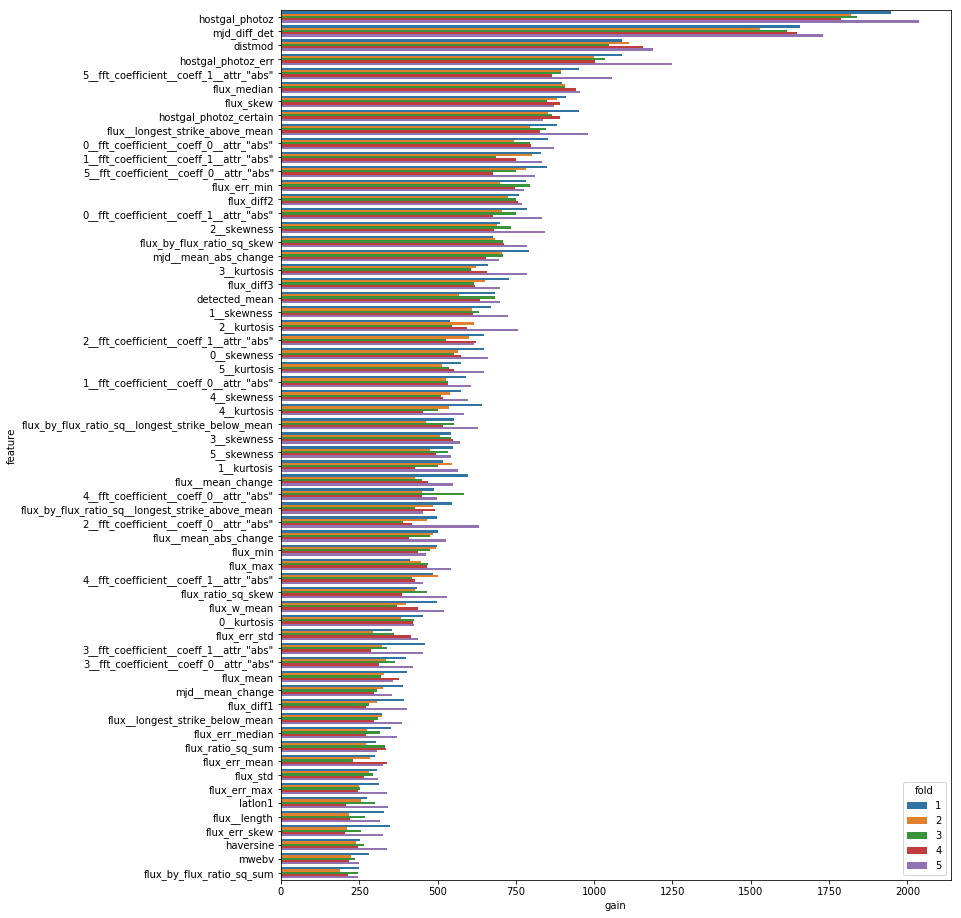

In [18]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=importances.sort_values(by='mean_gain', ascending=False), x='gain', y='feature', hue='fold', )
plt.show()

### Scaling features before training

In [19]:
from sklearn.preprocessing import StandardScaler

In [20]:
scaler = StandardScaler()
X_scaled_vals = scaler.fit_transform(X)

In [21]:
X_scaled = pd.DataFrame(X_scaled_vals, columns=X.columns, index=X.index)

In [22]:
%%time
# modeling from CV
scaled_results = train_and_validate(
    X=X_scaled, 
    y=y, 
    feature_colnames=default_feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params=lgbm_params, 
    nr_fold=5, 
    random_state=1
)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.748567	training's wloss: 0.740549	valid_1's multi_logloss: 1.09901	valid_1's wloss: 0.9331
[200]	training's multi_logloss: 0.490627	training's wloss: 0.48013	valid_1's multi_logloss: 0.875799	valid_1's wloss: 0.729899
[300]	training's multi_logloss: 0.388303	training's wloss: 0.376497	valid_1's multi_logloss: 0.797522	valid_1's wloss: 0.674669
[400]	training's multi_logloss: 0.328264	training's wloss: 0.31655	valid_1's multi_logloss: 0.757189	valid_1's wloss: 0.659614
[500]	training's multi_logloss: 0.285739	training's wloss: 0.274195	valid_1's multi_logloss: 0.729794	valid_1's wloss: 0.654885
[600]	training's multi_logloss: 0.252098	training's wloss: 0.241174	valid_1's multi_logloss: 0.709347	valid_1's wloss: 0.654662
Early stopping, best iteration is:
[559]	training's multi_logloss: 0.265167	training's wloss: 0.253978	valid_1's multi_logloss: 0.716039	valid_1's wloss: 0.653649
no 1-fold lo

In [23]:
scaled_results.score - score

0.003458128606712796

This did not improve the performance, but it should allow us to perform PCA and other features selection methods.

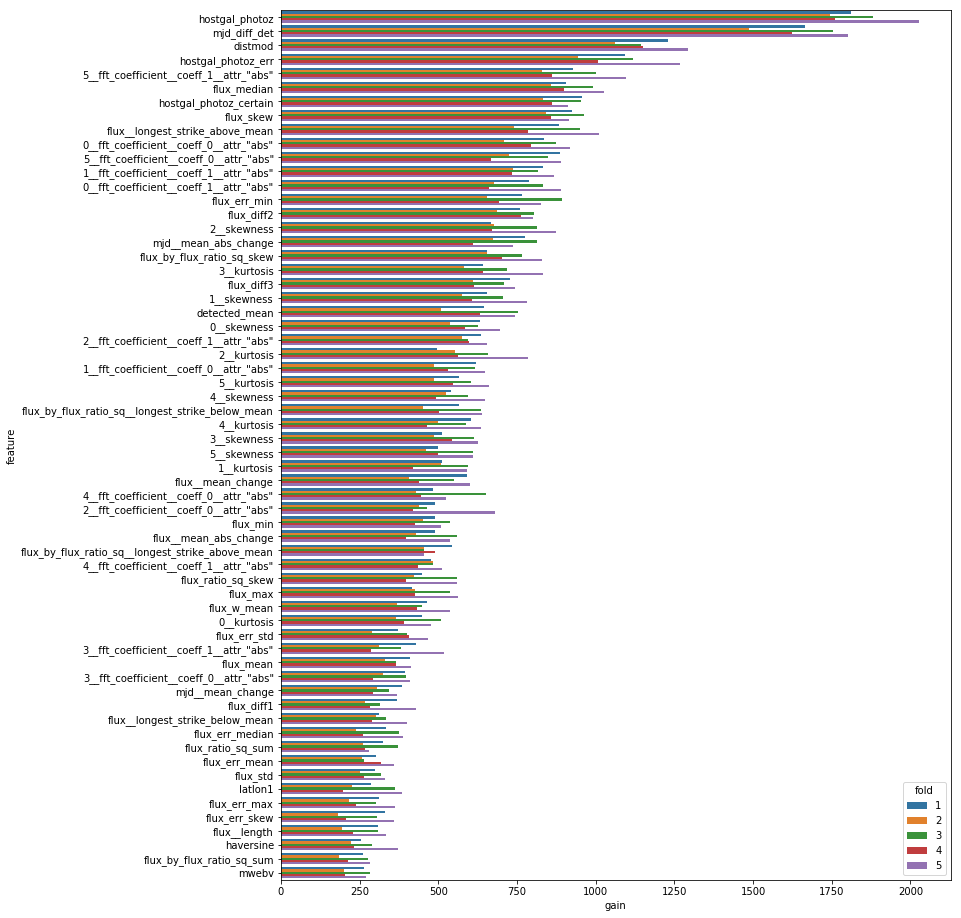

In [24]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=scaled_results.importances.sort_values(by='mean_gain', ascending=False), x='gain', y='feature', hue='fold', )
plt.show()

### Let's check which features have the highest importance variance - this hints that model is overfitting on that particular feature

In [25]:
var_coef = pd.DataFrame({
    'feature': scaled_results.importances.groupby('feature').count().index,
    'cv': scaled_results.importances.groupby('feature').std()['gain'] / scaled_results.importances.groupby('feature').mean()['gain']
})

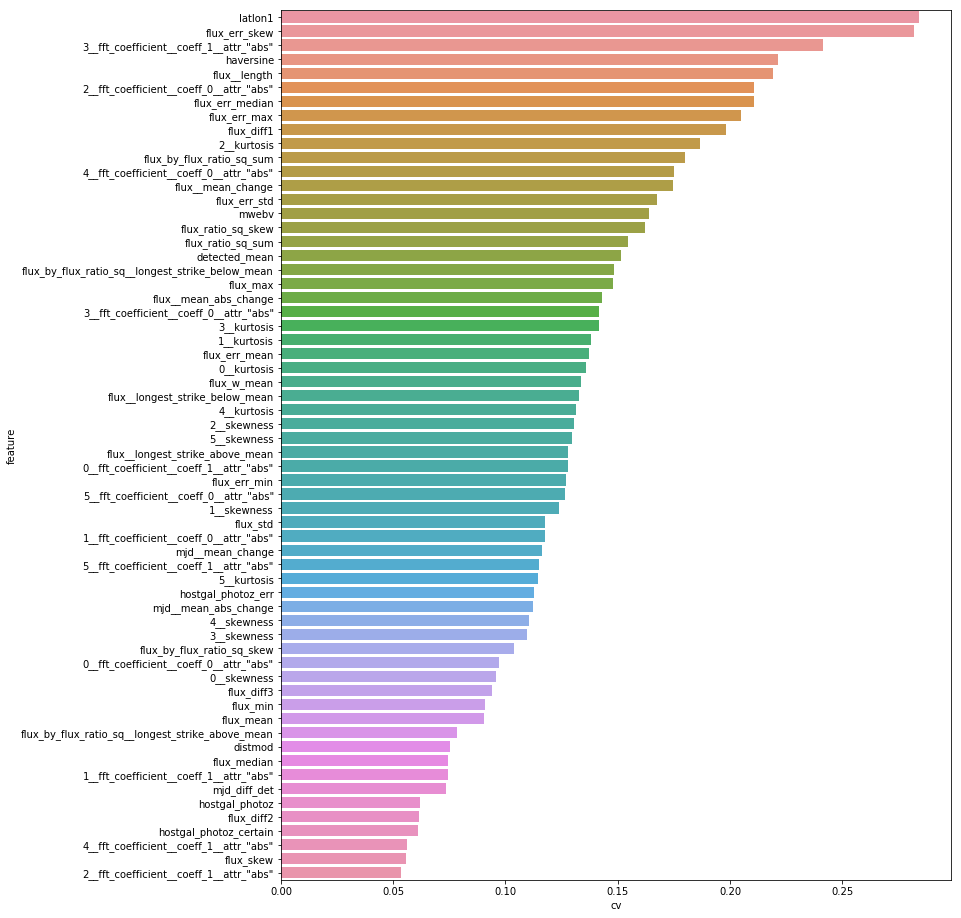

In [26]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=var_coef.sort_values(by='cv', ascending=False), x='cv', y='feature')
plt.show()

### Eliminating features by variance and coefficient of importance variation
Most of the features above have rather stable coefficient of variation - this means that they are, more or less, equally important to all models in CV and therefore they are legitimate features.
However, if some of the features with higher cv also have low variance, we might want to eliminate them.

In [27]:
variances = X_default.var()  # we use original X - X_scaled all have variance squashed to 1

In [28]:
variances.head()

flux_min       1.801061e+08
flux_max       8.221582e+08
flux_mean      3.338050e+06
flux_median    6.689928e+05
flux_std       1.513715e+07
dtype: float64

In [29]:
variances.name = 'variance'

In [30]:
variance_df = var_coef.join(variances, on='feature')

In [31]:
variance_df.head()

,feature,cv,variance
feature,,,
"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_0__attr_""abs""",0.096940,6.545591e+08
"0__fft_coefficient__coeff_1__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0.127711,2.796221e+09
0__kurtosis,0__kurtosis,0.135722,5.739111e+01
0__skewness,0__skewness,0.095734,2.435061e+00
"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_0__attr_""abs""",0.117539,1.344199e+08


In [32]:
from sklearn.preprocessing import minmax_scale

In [33]:
normalized_inverse_variance = np.divide(1, minmax_scale(variance_df['variance'].values, feature_range=(0,1)))
variance_df['elimination_score'] = variance_df['cv'] * 1 / normalized_inverse_variance

In [34]:
variance_df = variance_df.sort_values(by='elimination_score', ascending=False)
variance_df.head()

,feature,cv,variance,elimination_score
feature,,,,
flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_sum,0.180031,9.450461e+18,1.800306e-01
flux_ratio_sq_sum,flux_ratio_sq_sum,0.154711,3.532918e+11,5.783649e-09
"5__fft_coefficient__coeff_0__attr_""abs""","5__fft_coefficient__coeff_0__attr_""abs""",0.126642,6.680262e+09,8.951952e-11
"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_0__attr_""abs""",0.175054,3.289718e+09,6.093637e-11
"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_0__attr_""abs""",0.210896,1.920887e+09,4.286642e-11


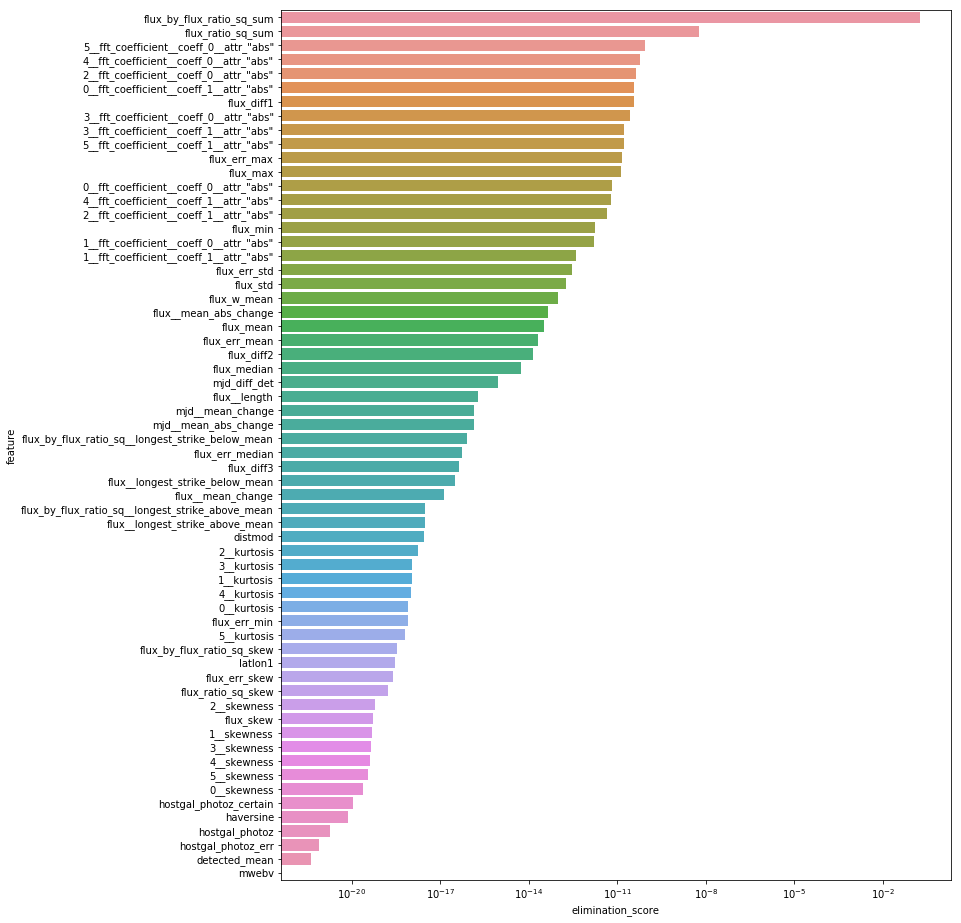

In [35]:
fig, ax = plt.subplots(figsize=(12,16))
ax = sns.barplot(ax=ax, data=variance_df, x='elimination_score', y='feature')
ax.set_xscale('log')
plt.show()

In [36]:
eliminate_by_low_variance = variance_df[variance_df['variance'] < 1]
eliminate_by_low_variance

,feature,cv,variance,elimination_score
feature,,,,
haversine,haversine,0.221323,0.339588,7.421751e-21
hostgal_photoz,hostgal_photoz,0.061964,0.297626,1.802759e-21
hostgal_photoz_err,hostgal_photoz_err,0.112814,0.090221,8.062646e-22
detected_mean,detected_mean,0.151323,0.049898,4.358236e-22
mwebv,mwebv,0.163994,0.022680,0.000000e+00


In [37]:
eliminate_by_high_importance_variation = variance_df[variance_df['cv'] > 0.25]
eliminate_by_high_importance_variation

,feature,cv,variance,elimination_score
feature,,,,
latlon1,latlon1,0.284010,9.970127,2.989454e-19
flux_err_skew,flux_err_skew,0.281993,8.799306,2.618865e-19


In [38]:
eliminate_by_both = variance_df[variance_df['elimination_score'] > 1e-10]
eliminate_by_both

,feature,cv,variance,elimination_score
feature,,,,
flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_sum,0.180031,9.450461e+18,1.800306e-01
flux_ratio_sq_sum,flux_ratio_sq_sum,0.154711,3.532918e+11,5.783649e-09


In [39]:
eliminate_colnames = set(eliminate_by_low_variance.index.values) \
        | set(eliminate_by_high_importance_variation.index.values) \
        | set(eliminate_by_both.index.values)

In [40]:
eliminate_colnames

{'detected_mean',
 'flux_by_flux_ratio_sq_sum',
 'flux_err_skew',
 'flux_ratio_sq_sum',
 'haversine',
 'hostgal_photoz',
 'hostgal_photoz_err',
 'latlon1',
 'mwebv'}

We will run mlflow experiment to check whether elimination of these columns improves CV score

In [41]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [42]:
from itertools import chain, combinations
from typing import Set

import mlflow
from experiments import log_args, start_run
from tqdm import tqdm

In [43]:
experiment_lgbm_params = lgbm_params.copy()
experiment_lgbm_params['verbosity'] = 0
experiment_lgbm_params

{'device': 'cpu',
 'objective': 'multiclass',
 'num_class': 14,
 'boosting_type': 'gbdt',
 'n_jobs': 16,
 'max_depth': 7,
 'n_estimators': 1024,
 'subsample_freq': 2,
 'subsample_for_bin': 5000,
 'min_data_per_group': 100,
 'max_cat_to_onehot': 4,
 'cat_l2': 1.0,
 'cat_smooth': 59.5,
 'max_cat_threshold': 32,
 'metric_freq': 10,
 'verbosity': 0,
 'metric': 'multi_logloss',
 'xgboost_dart_mode': False,
 'uniform_drop': False,
 'colsample_bytree': 0.5,
 'drop_rate': 0.173,
 'learning_rate': 0.0267,
 'max_drop': 5,
 'min_child_samples': 10,
 'min_child_weight': 100.0,
 'min_split_gain': 0.1,
 'num_leaves': 7,
 'reg_alpha': 0.1,
 'reg_lambda': 0.00023,
 'skip_drop': 0.44,
 'subsample': 0.75}

In [44]:
experiment_colnames_to_eliminate = set(powerset(eliminate_colnames))
len(experiment_colnames_to_eliminate)

512

In [50]:
def log_colnames(dropped: Set[str], all_colnames: Set[str]=eliminate_colnames):
    for colname in all_colnames:
        mlflow.log_param(f'{colname}_dropped', (colname in dropped))

In [51]:
def col_elimination_experiment(X: pd.DataFrame, cols_to_drop: Set[str]):
    log_colnames(cols_to_drop)
    clfs, score, scaled_importances = train_and_validate(
        X=X, 
        y=y, 
        feature_colnames=list(set(default_feature_colnames) - cols_to_drop), 
        id_colname=id_colname, 
        model='lgbm', 
        model_params=experiment_lgbm_params, 
        nr_fold=5, 
        random_state=1
    )
    mlflow.log_metric('multi_weighted_logloss_score', score)

In [52]:
%%time
# test to estimate experiment time
col_elimination_experiment(X, cols_to_drop=set())
mlflow.end_run()

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.74922	training's wloss: 0.741942	valid_1's multi_logloss: 1.0972	valid_1's wloss: 0.928386
[200]	training's multi_logloss: 0.491666	training's wloss: 0.48205	valid_1's multi_logloss: 0.875201	valid_1's wloss: 0.726529
[300]	training's multi_logloss: 0.388576	training's wloss: 0.377193	valid_1's multi_logloss: 0.797105	valid_1's wloss: 0.673786
[400]	training's multi_logloss: 0.328982	training's wloss: 0.317655	valid_1's multi_logloss: 0.758831	valid_1's wloss: 0.660027
Early stopping, best iteration is:
[438]	training's multi_logloss: 0.311616	training's wloss: 0.300273	valid_1's multi_logloss: 0.748248	valid_1's wloss: 0.657605
no 1-fold loss: 0.6576052408236207
Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.748139	training's wloss: 0.742383	valid_1's multi_logloss: 1.09554	valid_1's wloss: 0.952861
[200]	training's multi_logloss: 0.489663	tr

In [53]:
f"Expected experiment time: {len(experiment_colnames_to_eliminate) * 40 / 60} minutes"

'Expected experiment time: 341.3333333333333 minutes'

In [ ]:
mlflow.create_experiment(name='Eliminating features by variance')

In [53]:
from datetime import datetime
str(datetime.now())

'2018-12-09 06:24:07.704446'

In [ ]:
%%capture --no-stderr
for cols_to_drop in tqdm(experiment_colnames_to_eliminate):
    with start_run(experiment=2, source_name='Feature-Selection'):
        mlflow.log_param(key='scaled', value=True)
        col_elimination_experiment(X_scaled, cols_to_drop)
    with start_run(experiment=2, source_name='Feature-Selection'):
        mlflow.log_param(key='scaled', value=False)
        col_elimination_experiment(X, cols_to_drop)

 11%|█         | 56/512 [1:14:26<13:16:54, 104.86s/it]

### PCA

In [54]:
# Forum suggested that it is useless here